 **1. Load + Đọc file**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:

from google.colab import files
uploaded = files.upload()

Saving Dataset.xlsx to Dataset.xlsx


In [ ]:
import io
data = pd.read_excel(io.BytesIO(uploaded['Dataset.xlsx']))
print(data.head())

   Row ID        Order ID Order Date  Ship Date       Ship Mode Customer ID  \
0     646  CA-2017-126221 2017-12-30 2018-01-05  Standard Class    CC-12430   
1     907  CA-2017-143259 2017-12-30 2018-01-03  Standard Class    PO-18865   
2     908  CA-2017-143259 2017-12-30 2018-01-03  Standard Class    PO-18865   
3     909  CA-2017-143259 2017-12-30 2018-01-03  Standard Class    PO-18865   
4    1297  CA-2017-115427 2017-12-30 2018-01-03  Standard Class    EB-13975   

       Channel  Postal Code       Product ID    Sales  Quantity  Unit Cost  
0  Home Office        47201  OFF-AP-10002457  209.300         2    76.3945  
1     Consumer        10009  FUR-BO-10003441  323.136         4    77.7546  
2     Consumer        10009  TEC-PH-10004774   90.930         7    12.6003  
3     Consumer        10009  OFF-BI-10003684   52.776         3    10.9950  
4    Corporate        94533  OFF-BI-10002103   13.904         2     4.6926  


**2. Loại bỏ Returned Orders**

In [ ]:
data_orders = pd.read_excel(io.BytesIO(uploaded['Dataset.xlsx']), 'Orders')

data_return = data = pd.read_excel(io.BytesIO(uploaded['Dataset.xlsx']), 'Return')

data_orders_all = pd.merge(data_orders, data_return, on = 'Order ID', how = 'left', indicator=True)
data_ordered = data_orders_all[data_orders_all['_merge'] == 'left_only']
print(data_ordered)

      Row ID        Order ID Order Date  Ship Date       Ship Mode  \
0        646  CA-2017-126221 2017-12-30 2018-01-05  Standard Class   
1        907  CA-2017-143259 2017-12-30 2018-01-03  Standard Class   
2        908  CA-2017-143259 2017-12-30 2018-01-03  Standard Class   
3        909  CA-2017-143259 2017-12-30 2018-01-03  Standard Class   
6       5092  CA-2017-156720 2017-12-30 2018-01-03  Standard Class   
...      ...             ...        ...        ...             ...   
9989    1760  CA-2014-141817 2014-01-05 2014-01-12  Standard Class   
9990     740  CA-2014-112326 2014-01-04 2014-01-08  Standard Class   
9991     741  CA-2014-112326 2014-01-04 2014-01-08  Standard Class   
9992     742  CA-2014-112326 2014-01-04 2014-01-08  Standard Class   
9993    7981  CA-2014-103800 2014-01-03 2014-01-07  Standard Class   

     Customer ID      Channel  Postal Code       Product ID    Sales  \
0       CC-12430  Home Office        47201  OFF-AP-10002457  209.300   
1       PO-1886

**3. Tính Recency: Thời gian kể từ lần giao dịch cuối cùng**



In [ ]:
#Thêm cột ngày 31/12/2017
data_ordered = data_ordered.assign(Now = '2017 - 12 - 31')
data_ordered['Now'] = pd.to_datetime(data_ordered['Now'])

#Tính tg order kể từ ngày order gần nhất của mỗi KH: Recency
data_ordered['diff days'] = data_ordered['Now'] - data_ordered['Order Date']
last_ordered = data_ordered.groupby('Customer ID')['diff days'].min().reset_index(name='Since_last_order')

#Tính R
last_ordered['R'] = pd.qcut(last_ordered['Since_last_order'], q = 5, labels = ['5', '4', '3', '2', '1'])
print(last_ordered)

    Customer ID Since_last_order  R
0      AA-10315         185 days  2
1      AA-10375          20 days  5
2      AA-10480         260 days  2
3      AA-10645         483 days  1
4      AB-10015         416 days  1
..          ...              ... ..
786    XP-21865          83 days  3
787    YC-21895           5 days  5
788    YS-21880          10 days  5
789    ZC-21910          55 days  4
790    ZD-21925         203 days  2

[791 rows x 3 columns]


**4. Tính Frequency: Số lần khách hàng đã mua hàng trong một khoảng thời gian nhất định**

In [ ]:
times_ordered = data_ordered.groupby('Customer ID')['Order ID'].nunique().reset_index(name='times_order')
times_ordered['F'] = pd.qcut(times_ordered['times_order'], q = 5, labels = ['1', '2', '3', '4', '5'])
print(times_ordered)

    Customer ID  times_order  F
0      AA-10315            5  2
1      AA-10375            9  5
2      AA-10480            4  1
3      AA-10645            5  2
4      AB-10015            3  1
..          ...          ... ..
786    XP-21865            9  5
787    YC-21895            4  1
788    YS-21880            8  4
789    ZC-21910           12  5
790    ZD-21925            4  1

[791 rows x 3 columns]


**5. Tính Monetory: Tổng giá trị các giao dịch mà khách hàng đã thực hiện**

In [ ]:
#Thêm cột doanh thu
data_ordered['Revenue'] = data_ordered['Sales'] * data_ordered['Quantity']
revenue_ordered = data_ordered.groupby('Customer ID')['Revenue'].sum().reset_index(name='revenue_order')
revenue_ordered['M'] = pd.qcut(revenue_ordered['revenue_order'], q = 5, labels = ['1', '2', '3', '4', '5'])
print(revenue_ordered)

##cột doanh thu = tổng cột sales thôi, ko cần nhân quantity nhe

    Customer ID  revenue_order  M
0      AA-10315      16073.344  4
1      AA-10375       2734.830  1
2      AA-10480       5493.936  2
3      AA-10645      22901.935  5
4      AB-10015       1984.480  1
..          ...            ... ..
786    XP-21865       7425.602  3
787    YC-21895      27130.426  5
788    YS-21880      46478.992  5
789    ZC-21910      39889.178  5
790    ZD-21925       5744.008  2

[791 rows x 3 columns]


**6. Tìm RFM của mỗi KH**

In [ ]:
merge1 = pd.merge(last_ordered, times_ordered, on = 'Customer ID')
RFM = pd.merge(merge1, revenue_ordered, on = 'Customer ID')
RFM['RFM Score'] = RFM['R'].astype('str') + RFM['F'].astype('str') + RFM['M'].astype('str')
RFM['RFM Score'].astype(int)
print(RFM)

    Customer ID Since_last_order  R  times_order  F  revenue_order  M  \
0      AA-10315         185 days  2            5  2      16073.344  4   
1      AA-10375          20 days  5            9  5       2734.830  1   
2      AA-10480         260 days  2            4  1       5493.936  2   
3      AA-10645         483 days  1            5  2      22901.935  5   
4      AB-10015         416 days  1            3  1       1984.480  1   
..          ...              ... ..          ... ..            ... ..   
786    XP-21865          83 days  3            9  5       7425.602  3   
787    YC-21895           5 days  5            4  1      27130.426  5   
788    YS-21880          10 days  5            8  4      46478.992  5   
789    ZC-21910          55 days  4           12  5      39889.178  5   
790    ZD-21925         203 days  2            4  1       5744.008  2   

    RFM Score  
0         224  
1         551  
2         212  
3         125  
4         111  
..        ...  
786       3

**7. Tìm Segment của mỗi KH**

In [ ]:
data_segmentation = pd.read_excel(io.BytesIO(uploaded['Dataset.xlsx']), 'Segmentation')

#giải nén cột RFM score
data_segmentation['RFM Score'] = data_segmentation['RFM Score'].str.split(', ')
df_segmentation = pd.DataFrame({
    'Segment': data_segmentation['Segment'].repeat(data_segmentation['RFM Score'].str.len()),
    'RFM Score': [score for scores in data_segmentation['RFM Score'] for score in scores]
})

# In kết quả
print(df_segmentation)
data_customer = pd.merge(RFM, df_segmentation, on = 'RFM Score', how = 'left')
print(data_customer)

           Segment RFM Score
0        Champions       555
0        Champions       554
0        Champions       544
0        Champions       545
0        Champions       454
..             ...       ...
10  Lost customers       112
10  Lost customers       121
10  Lost customers       131
10  Lost customers       141
10  Lost customers       151

[122 rows x 2 columns]
    Customer ID Since_last_order  R  times_order  F  revenue_order  M  \
0      AA-10315         185 days  2            5  2      16073.344  4   
1      AA-10375          20 days  5            9  5       2734.830  1   
2      AA-10480         260 days  2            4  1       5493.936  2   
3      AA-10645         483 days  1            5  2      22901.935  5   
4      AB-10015         416 days  1            3  1       1984.480  1   
..          ...              ... ..          ... ..            ... ..   
786    XP-21865          83 days  3            9  5       7425.602  3   
787    YC-21895           5 days  5         

**8. Analysis**

**8.1 Tổng quan**

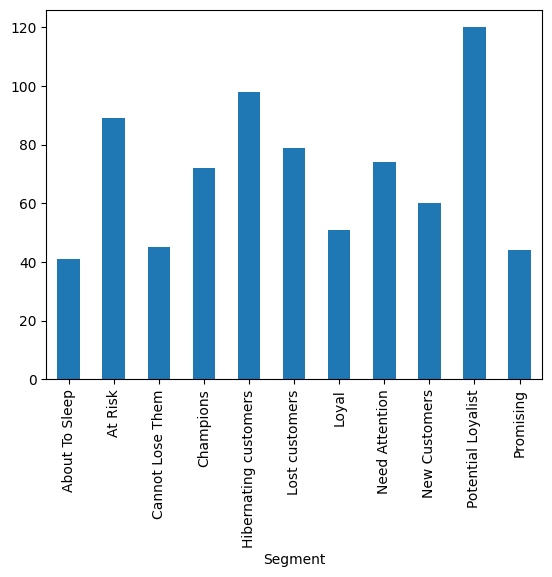

In [ ]:
#số lượng KH  theo từng nhóm
data_count_group = data_customer.groupby('Segment')['Customer ID'].count()
data_count_group.plot(kind = 'bar')
plt.show()

=> 3 nhóm có số lượng khách nhiều nhất: Potential Loyalist, Hibernating customers, At Risk

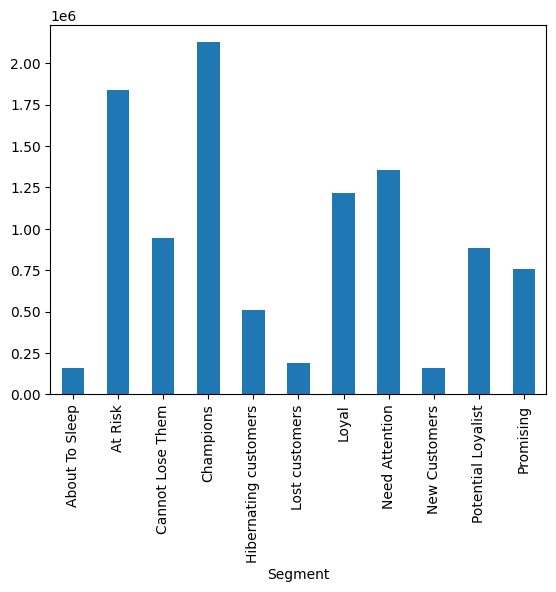

In [ ]:
#doanh thu của từng nhóm KH
data_revenue_group = data_customer.groupby('Segment')['revenue_order'].sum()
data_revenue_group.plot(x = 'Segment', kind = 'bar')
plt.show()


- 2 nhóm mang lại doanh thu cao nhất là **Champions** và **At Risk**
- Các nhóm có doanh thu cao tiếp theo: **Need Attention, Loyal, Cannot Lose Them, Potential Loyalist, Promising**
- 4 nhóm có doanh thu thấp nhất: Hibernating customers , Lost Customers, About to sleep, New customer

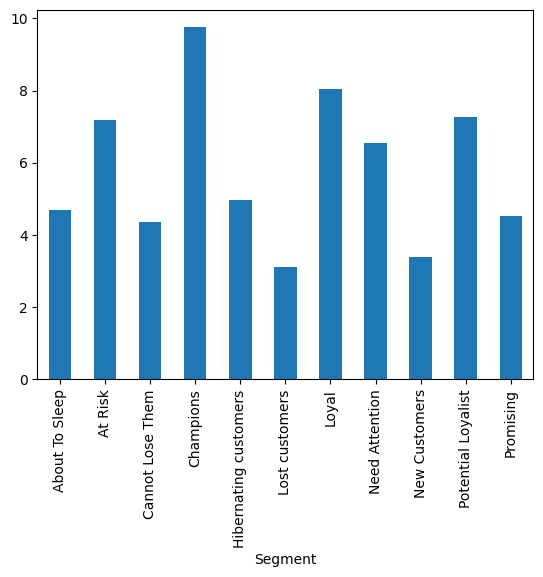

In [ ]:
#tần suất mua của từng nhóm
data_frequence_group = data_customer.groupby('Segment')['times_order'].mean()
data_frequence_group.plot(kind = 'bar')
plt.show()

- **Champions và Loyal** là 2 nhóm order thường xuyên nhất (8 - 10 lần/năm)
- Potential Loyalist, At risk, Need Attention order trung bình 6 - 8 lần/năm
- Các nhóm còn lại 3 - 6 orders/năm

**8.2 Đưa ra recommend cho bộ phận Marketing**

Mục đích của bộ phận Marketing là muốn có những chương trình phù hợp với từng nhóm KH. Đặc biệt muốn nhóm KH Potential Loyalist => Loyal
- Nhóm Potential Loyalist đang có số lượng nhiều nhất
- tần suất order trung bình (7-8 lần/năm)
- Tuy nhiên, doanh thu còn đang khá thấp
Để trở thành nhóm Loyal, cần có chương trình ưu đãi nhằm tăng giá trị đơn hàng (tăng số lượng mua trong 1 đơn hoặc khuyến khích họ mua những mặt hàng có giá trị cao hơn)

**8.2.1 Tỷ lệ channel trong nhóm Potential Poyalist**

<Axes: xlabel='Channel', ylabel='count'>

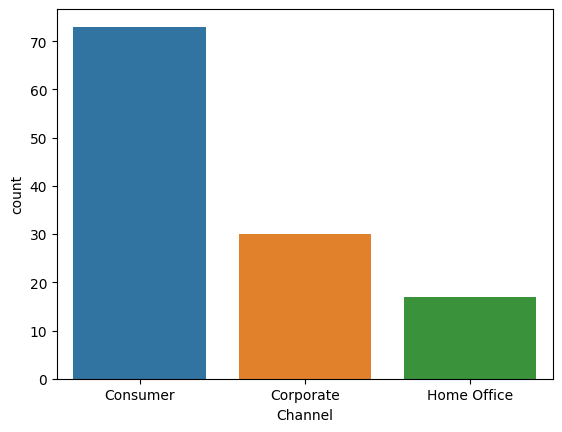

In [ ]:
#Mỗi KH đã có phân Segment thuộc Channel nào
customer_channel = pd.merge(data_customer, data_orders[['Customer ID', 'Channel']], on = 'Customer ID', how = 'left')
customer_channel = customer_channel.drop_duplicates(subset = 'Customer ID')
Potential = customer_channel[customer_channel['Segment'] == 'Potential Loyalist']
Potential

#Tìm nhóm Potential có tỷ lệ channel ntn

sns.countplot(data = Potential, x = 'Channel')


=> Trong nhóm Potential Loyalist, số lượng KH là **Consumer chiếm > 50%**. Có thể tập trung chính vào nhóm đối tượng này để đưa ra chương trình khuyến mại phù hợp


<Axes: xlabel='Channel', ylabel='revenue_order'>

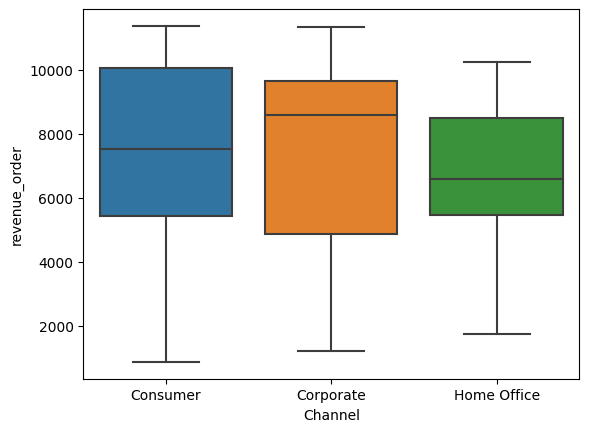

In [ ]:
sns.boxplot(data = Potential, x = 'Channel', y = 'revenue_order')


=> Mỗi Channel có trung bình chi trả không quá chênh lệch
- 1 KH là Corporate chi tiêu chủ yếu 5000 - 10000/năm
- 1 KH là Consumer chi tiêu chủ yếu ~ 6000 - 10000/năm
- 1 KH là Corporate chi tiêu chủ yếu 6000 - ~ 9000/năm

**8.2.2 Tìm ra Category/Sub Category nào được Customer/Corporate/Home Office (trong nhóm Potential Loyalist) mua nhiều**

merge data_ordered với product (cate và sub cate) - theo product id

=> merge tiếp với data_customer( customer id, segment) - theo customer id để tìm segment

=> chỉ lấy 'Potential loyalist'

=> cate/subcate nào có doanh số/lợi nhuận tốt nhất ở mỗi channel.
cate/subcate có xu hướng tăng gần đây ở mỗi channel (theo time order)

In [ ]:
data_product = pd.read_excel(io.BytesIO(uploaded['Dataset.xlsx']), 'Product')
customer_product = pd.merge(data_ordered, data_product[['Category', 'Sub-Category', 'Product ID']], on = 'Product ID', how = 'left')
customer_product = customer_product[['Order ID', 'Customer ID', 'Channel', 'Product ID', 'Sales', 'Quantity', 'Unit Cost', 'Category', 'Sub-Category']]
customer_product = customer_product.drop_duplicates(subset = ['Product ID', 'Order ID'])



,Order ID,Customer ID,Channel,Product ID,Sales,Quantity,Unit Cost,Category,Sub-Category
0,CA-2017-126221,CC-12430,Home Office,OFF-AP-10002457,209.300,2,76.3945,Office Supplies,Appliances
1,CA-2017-143259,PO-18865,Consumer,FUR-BO-10003441,323.136,4,77.7546,Furniture,Bookcases
2,CA-2017-143259,PO-18865,Consumer,TEC-PH-10004774,90.930,7,12.6003,Technology,Phones
3,CA-2017-143259,PO-18865,Consumer,OFF-BI-10003684,52.776,3,10.9950,Office Supplies,Binders
4,CA-2017-156720,JM-15580,Consumer,OFF-FA-10003472,3.024,3,1.2096,Office Supplies,Fasteners
...,...,...,...,...,...,...,...,...,...
9495,CA-2014-141817,MB-18085,Consumer,OFF-AR-10003478,19.536,3,4.8840,Office Supplies,Art
9496,CA-2014-112326,PO-19195,Home Office,OFF-LA-10003223,11.784,3,2.5041,Office Supplies,Labels
9497,CA-2014-112326,PO-19195,Home Office,OFF-ST-10002743,272.736,3,112.5036,Office Supplies,Storage
9498,CA-2014-112326,PO-19195,Home Office,OFF-BI-10004094,3.540,2,4.5135,Office Supplies,Binders


In [ ]:
customer_product_df = pd.merge(customer_product, data_customer[['Customer ID', 'Segment']], on = 'Customer ID', how = 'left')
Potential_product = customer_product_df[customer_product_df['Segment'] == 'Potential Loyalist']
Potential_product['Total Cost'] = Potential_product['Quantity'] * Potential_product['Unit Cost']
Potential_product['Profit'] = Potential_product['Sales'] - Potential_product['Total Cost']


<ipython-input-32-e953977e51c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Potential_product['Total Cost'] = Potential_product['Quantity'] * Potential_product['Unit Cost']
<ipython-input-32-e953977e51c5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Potential_product['Profit'] = Potential_product['Sales'] - Potential_product['Total Cost']


,Order ID,Customer ID,Channel,Product ID,Sales,Quantity,Unit Cost,Category,Sub-Category,Segment,Total Cost,Profit
1,CA-2017-143259,PO-18865,Consumer,FUR-BO-10003441,323.136,4,77.7546,Furniture,Bookcases,Potential Loyalist,311.0184,12.1176
2,CA-2017-143259,PO-18865,Consumer,TEC-PH-10004774,90.930,7,12.6003,Technology,Phones,Potential Loyalist,88.2021,2.7279
3,CA-2017-143259,PO-18865,Consumer,OFF-BI-10003684,52.776,3,10.9950,Office Supplies,Binders,Potential Loyalist,32.9850,19.7910
40,CA-2017-163510,JW-15955,Consumer,OFF-ST-10000563,95.940,3,28.7820,Office Supplies,Storage,Potential Loyalist,86.3460,9.5940
41,CA-2017-163510,JW-15955,Consumer,FUR-CH-10001146,304.450,5,45.6675,Furniture,Chairs,Potential Loyalist,228.3375,76.1125
...,...,...,...,...,...,...,...,...,...,...,...,...
9148,CA-2014-115791,DL-13315,Consumer,FUR-FU-10001095,127.104,6,16.4176,Furniture,Furnishings,Potential Loyalist,98.5056,28.5984
9149,CA-2014-115791,DL-13315,Consumer,TEC-PH-10004614,124.200,3,51.7500,Technology,Phones,Potential Loyalist,155.2500,-31.0500
9150,CA-2014-115791,DL-13315,Consumer,OFF-BI-10001575,18.588,2,16.1096,Office Supplies,Binders,Potential Loyalist,32.2192,-13.6312
9151,CA-2014-115791,DL-13315,Consumer,OFF-LA-10001074,30.072,3,6.6409,Office Supplies,Labels,Potential Loyalist,19.9227,10.1493


<Axes: xlabel='Channel', ylabel='Sales'>

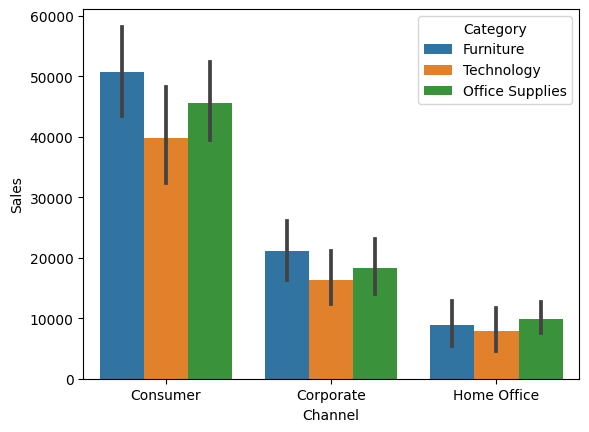

In [ ]:
sns.barplot(data = Potential_product, x = 'Channel', y = 'Sales', estimator = sum, hue = 'Category')


- Với channel Consumer: Nhóm sp Furrniture có Revenue cao nhất -> Office Supplies -> Technology
- Với channel Corporate: Nhóm sp Furrniture có Revenue cao nhất -> Office Supplies -> Technology
- Với channel Home Office: Nhóm sp Office Supplies có Revenue cao nhất -> Furniture -> Technology

<Axes: xlabel='Channel', ylabel='Profit'>

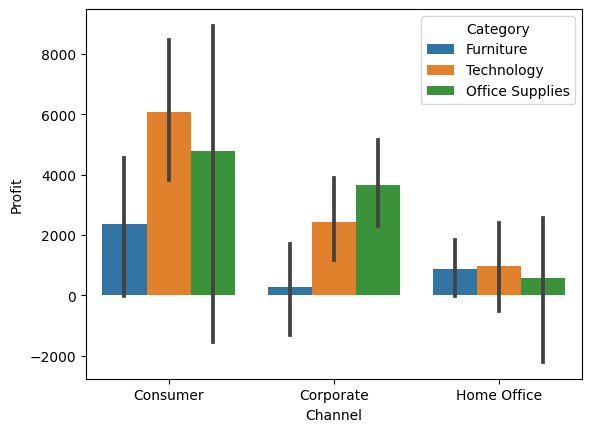

In [ ]:
sns.barplot(data = Potential_product, x = 'Channel', y = 'Profit', estimator = sum, hue = 'Category')

- Với channel Consumer: Nhóm sp Technology mang lại lợi nhuận cao nhất -> Office Supplies -> Furniture
- Với channel Corporate: Nhóm sp Office Supplies mang lại lợi nhuận cao nhất -> Technology -> Furniture
- Với channel Home Office: Nhóm sp Technology mang lại lợi nhuận cao nhất -> Office Furniture -> Office Supplies

=> Đối với channel **Consumer**
- Mặc dù nhóm sp Furniture có Revenue cao nhất nhưng mang lại Profit thấp nhất -> Bộ phận Marketing cần cân nhắc ko nên lựa chọn nhóm sp này với chương trình giảm giá
- Nhóm sp **Technology** có Revenue thấp hơn nhưng mang lại lợi nhuận tốt -> nên tập trung vào sp này trong chương trình sắp tới
- Nhóm sp Office Suppies có revenue khá tốt, profit trung bình -> có thể cân nhắc nhóm sp này

=> Đối với nhóm **Corporate**:
Nên tập trung chính vào **Office Supplies** vì vừa có revenue tốt, vừa có profit cao nhất => có thể cân nhắc thêm nhóm sp Technology

**Phân tích sâu Với mỗi channel, ở mỗi nhóm sp thì có sub-cate nào nên được đẩy mạnh ko??**

1. Channel consumer - Nhóm sp Technology

<Axes: xlabel='Sub-Category', ylabel='Sales'>

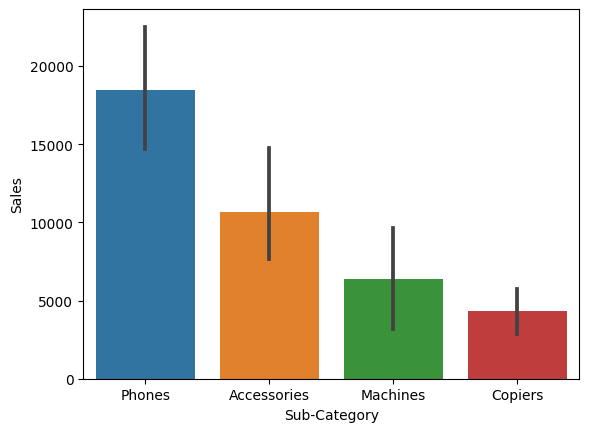

In [ ]:

Potential_customer_product = Potential_product[Potential_product['Channel'] == 'Consumer']
a = Potential_customer_product[Potential_customer_product['Category'] == 'Technology']
sns.barplot(data = a, x = 'Sub-Category', y = 'Sales', estimator = sum)

<Axes: xlabel='Sub-Category', ylabel='Profit'>

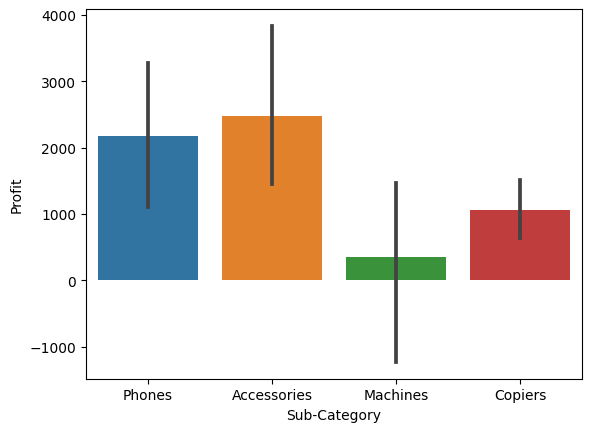

In [ ]:
sns.barplot(data = a, x = 'Sub-Category', y = 'Profit', estimator = sum)

=> Tập trung vào nhóm Accessories

2. Channel Corporate - Nhóm Office Supplies

<Axes: xlabel='Sub-Category', ylabel='Sales'>

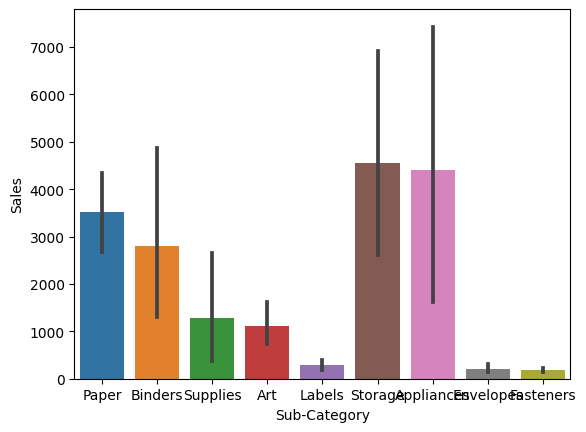

In [ ]:
Potential_customer_product = Potential_product[Potential_product['Channel'] == 'Corporate']
b = Potential_customer_product[Potential_customer_product['Category'] == 'Office Supplies']
sns.barplot(data = b, x = 'Sub-Category', y = 'Sales', estimator = sum)

<Axes: xlabel='Sub-Category', ylabel='Profit'>

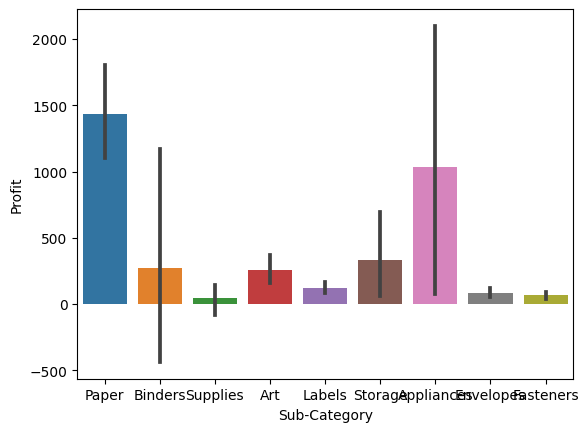

In [ ]:
sns.barplot(data = b, x = 'Sub-Category', y = 'Profit', estimator = sum)

=> Đẩy mạnh Paper và Appliances